# `HFSModel` Tutorial

Trey V. Wenger (c) July 2025

Here we demonstrate the basic features of the `HFSModel` model. The `HFSModel` models hyperfine spectral structure including non-CTEX effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 1+0.gc6f9e00.dirty


## Preparing Molecule Data

Here we model the hyperfine structure of CN transitions to the ground rotational state. We must first manually identify the transitions of interest and calculate the lower state degeneracies. (N.B., if anyone knows how to derive the lower state degeneracies programmatically from the information returned by CDMS, please let me know!)

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_12CN, all_mol_metadata_12CN = get_molecule_data("CN, v=0,1", fmin=100.0, fmax=200.0)
    with open("mol_data_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_12CN, f)
    with open("mol_metadata_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_12CN, f)
except:
    with open("mol_data_12CN.pkl", "rb") as f:
        all_mol_data_12CN = pickle.load(f)
    with open("mol_metadata_12CN.pkl", "rb") as f:
        all_mol_metadata_12CN = pickle.load(f)

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR    ELO    GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab 
    MHz      MHz   nm2 MHz       1 / cm        u                                                                             
----------- ------ ------- --- --------- --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- -----
 112101.656   0.05 -8.0612   2 2042.4216   2    26 5041   234   1   1   1   1  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112128.989   0.05  -8.069   2 2042.4222   4    26 5041   234   1   1   1   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112148.503   0.05 -7.9593   2 2042.4216   4    26 5041   234   1   1   1   2  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112442.806   0.05 -7.9569   2 2042.4222   4    26 5041   234   1   1   2   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112445.015   0.05 -7.5311   2 2042.4216   6    26 5041   234   1   1   2   3  --  --   0   1   1   2  --  -- CN, v=0,

In [3]:
# Keep only Kl = 0 transitions
all_mol_data_12CN = all_mol_data_12CN[all_mol_data_12CN["Kl"] == 0]

# Add GLO
all_mol_data_12CN["GLO"] = 2 * all_mol_data_12CN["F1l"]

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                                 
----------- ------ ------- --- ------ --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- ----- ---
113123.3701 0.0058 -4.7118   2 0.0007   2    26 5041   234   1   0   1   1  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113144.1573 0.0057 -3.7989   2   -0.0   2    26 5041   234   1   0   1   1  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113170.4915 0.0039  -3.809   2 0.0007   4    26 5041   234   1   0   1   2  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113191.2787 0.0034 -3.6955   2   -0.0   4    26 5041   234   1   0   1   2  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113488.1202 0.0033 -3.6932   2 0.0007   4    26 5041   234   1   0   2   2  --  --   0   0   1   1  --  -- CN, 

In [4]:
mol_data_12CN = supplement_molecule_data(all_mol_data_12CN, all_mol_metadata_12CN)
print(mol_data_12CN.keys())
print("molecular weight (Daltons):", mol_data_12CN['mol_weight'])
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Relative intensities:", mol_data_12CN['relative_int'])
print("state info:", mol_data_12CN["states"])
print("upper state index:", mol_data_12CN["state_u_idx"])
print("lower state index:", mol_data_12CN["state_l_idx"])
print("upper state degeneracy:", mol_data_12CN["Gu"])
print("lower state degeneracy:", mol_data_12CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 26
transition frequency (MHz): [113123.3701 113144.1573 113170.4915 113191.2787 113488.1202 113490.9702
 113499.6443 113508.9074 113520.4315]
Einstein A coefficient (s-1): [1.24997446e-06 1.02301076e-05 4.99866053e-06 6.49280964e-06
 6.54458098e-06 1.15851092e-05 1.03265758e-05 5.04267116e-06
 1.26251089e-06]
Relative intensities: [0.01204927 0.09859632 0.09632981 0.12510097 0.12576526 0.33393404
 0.0992112  0.09688593 0.0121272 ]
state info: {'state': [np.str_('0 0 1 1 -- --'), np.str_('0 0 1 2 -- --'), np.str_('1 0 1 1 -- --'), np.str_('1 0 1 2 -- --'), np.str_('1 0 2 1 -- --'), np.str_('1 0 2 2 -- --'), np.str_('1 0 2 3 -- --')], 'deg': array([2, 4, 2, 4, 2, 4, 6]), 'E': array([ 1.00714381e-03, -0.00000000e+00,  5.43007265e+00,  5.43233412e+00,
        5.44813096e+00,  5.44757789e+00,  5.44670753e+00])}
upper state index: [2, 2, 3, 3, 5, 6, 4, 5, 4

## Simulating Data

To test the model, we must simulate some data. We can do this with `HFSModel`, but we must pack a "dummy" data structure first. The observations can be named anything (e.g., "12CN-1" and "12CN-2" in this case).

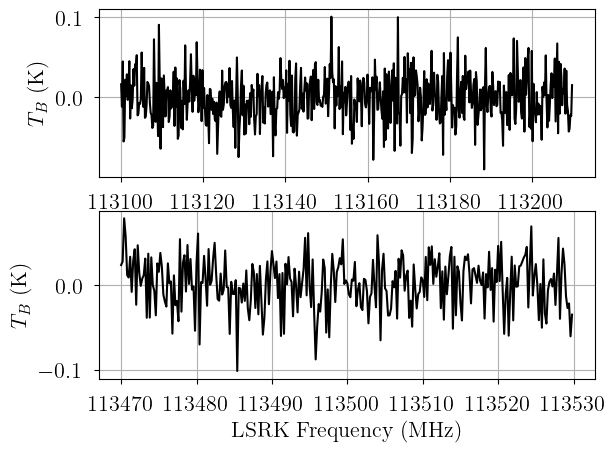

In [5]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# HFSModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of model parameters.

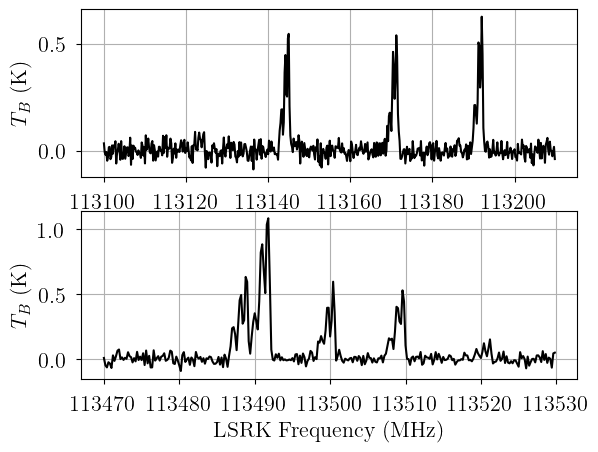

In [6]:
from bayes_hfs import HFSModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSModel(
    mol_data_12CN, # molecular data
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = True, # assume CTEX
    prior_log10_CTEX_variance = None, # ignored because CTEX
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot": np.array([13.8, 13.9, 14.0]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([4.46, 3.98, 3.16]),
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [7]:
sim_params

{'log10_Ntot': array([13.8, 13.9, 14. ]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.64933486, 0.59988307, 0.49968708]),
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'CTEX_weights': array([[1.99954842, 4.        , 0.59193533, 1.18327051, 0.58954346,
         1.17923313, 1.76919492],
        [1.99949396, 4.        , 0.51109864, 1.02161662, 0.5087849 ,
         1.01771121, 1.52690069],
        [1.99936267, 4.        , 0.35871387, 0.71691448, 0.35666979,
         0.71346443, 1.07049146]]),
 'Tex': array([4.46, 3.98, 3.16]),
 'tau': array([[0.02742294, 0.03901221, 0.06218552],
        [0.22442582, 0.31927704, 0.50895265],
        [0.21919336, 0.3118215 , 0.49702465],
        [0.28469915, 0.40501691, 0.6456038 ],
        [0.28578764, 0.40650805, 0.64778077],
        [0.75898784, 1.07962237, 1.72051429],
        [0.22543548, 0.32066093, 0.51097642],
        [0.22019236, 0.31321047, 0.49913295],
        [0.02756012

In [8]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `HFSModel`. Here we assume constant excitation temperature (CTEX).

In [9]:
# Initialize and define the model
model = HFSModel(
    mol_data_12CN, # molecular data
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = True, # assume CTEX
    prior_log10_CTEX_variance = None, # ignored because CTEX
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

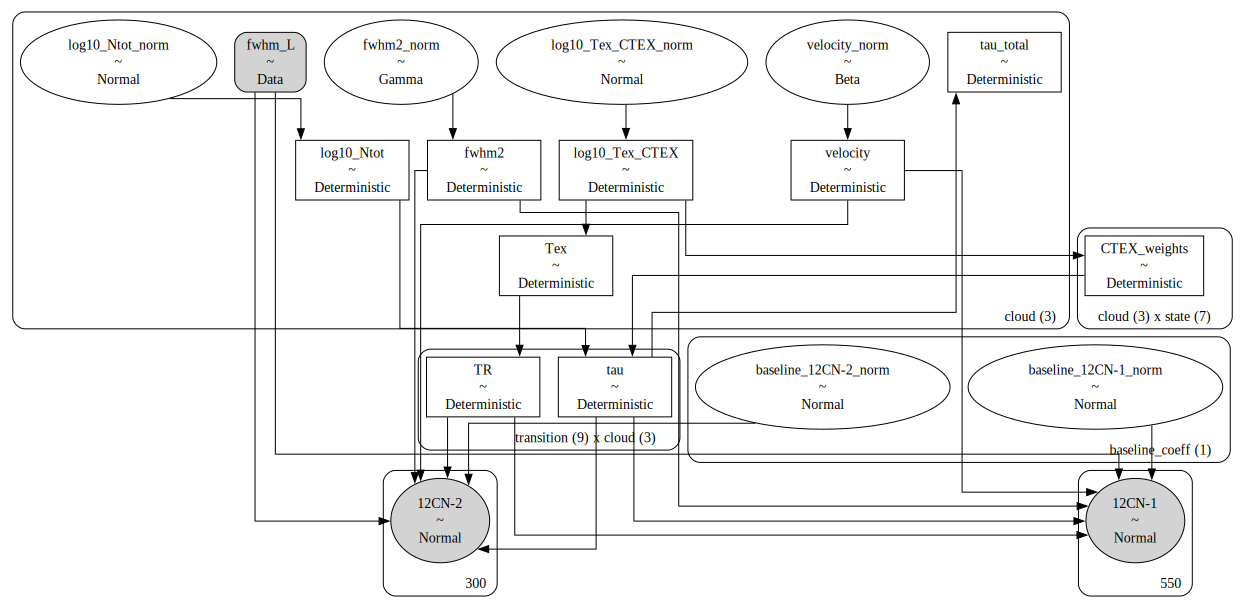

In [10]:
# Plot model graph
model.graph().render('hfs_model', format='png')
model.graph()

In [11]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, 1)
baseline_12CN-2_norm ~ Normal(0, 1)
     log10_Ntot_norm ~ Normal(0, 1)
          fwhm2_norm ~ Gamma(0.5, f())
       velocity_norm ~ Beta(2, 2)
 log10_Tex_CTEX_norm ~ Normal(0, 1)
          log10_Ntot ~ Deterministic(f(log10_Ntot_norm))
               fwhm2 ~ Deterministic(f(fwhm2_norm))
            velocity ~ Deterministic(f(velocity_norm))
      log10_Tex_CTEX ~ Deterministic(f(log10_Tex_CTEX_norm))
        CTEX_weights ~ Deterministic(f(log10_Tex_CTEX_norm))
                 Tex ~ Deterministic(f(log10_Tex_CTEX_norm))
                 tau ~ Deterministic(f(log10_Ntot_norm, log10_Tex_CTEX_norm))
           tau_total ~ Deterministic(f(log10_Ntot_norm, log10_Tex_CTEX_norm))
                  TR ~ Deterministic(f(log10_Tex_CTEX_norm))
              12CN-1 ~ Normal(f(baseline_12CN-1_norm, log10_Tex_CTEX_norm, velocity_norm, fwhm2_norm, log10_Ntot_norm), <constant>)
              12CN-2 ~ Normal(f(baseline_12CN-2_norm, log10_Tex_CTEX_norm, velocity_nor

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm2_norm, log10_Ntot_norm, log10_Tex_CTEX_norm, velocity_norm]


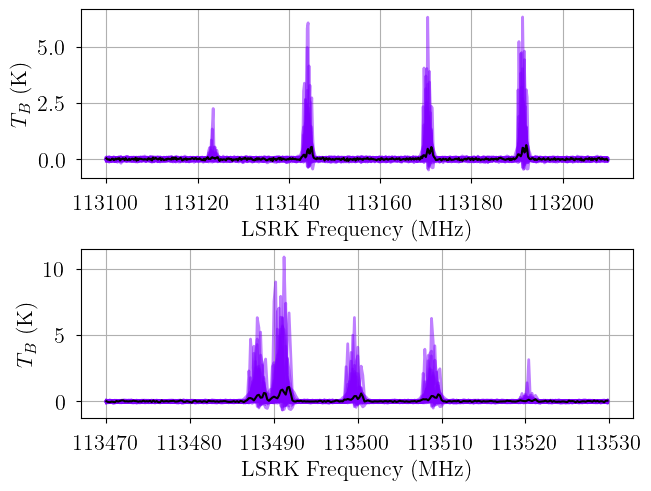

In [12]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))

We can also check out our prior distributions impact the deterministic (derived) quantities in our model. The red points represent the simulation parameters.

In [13]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm']
['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'CTEX_weights', 'Tex', 'tau', 'tau_total', 'TR']


['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'Tex', 'tau_total']


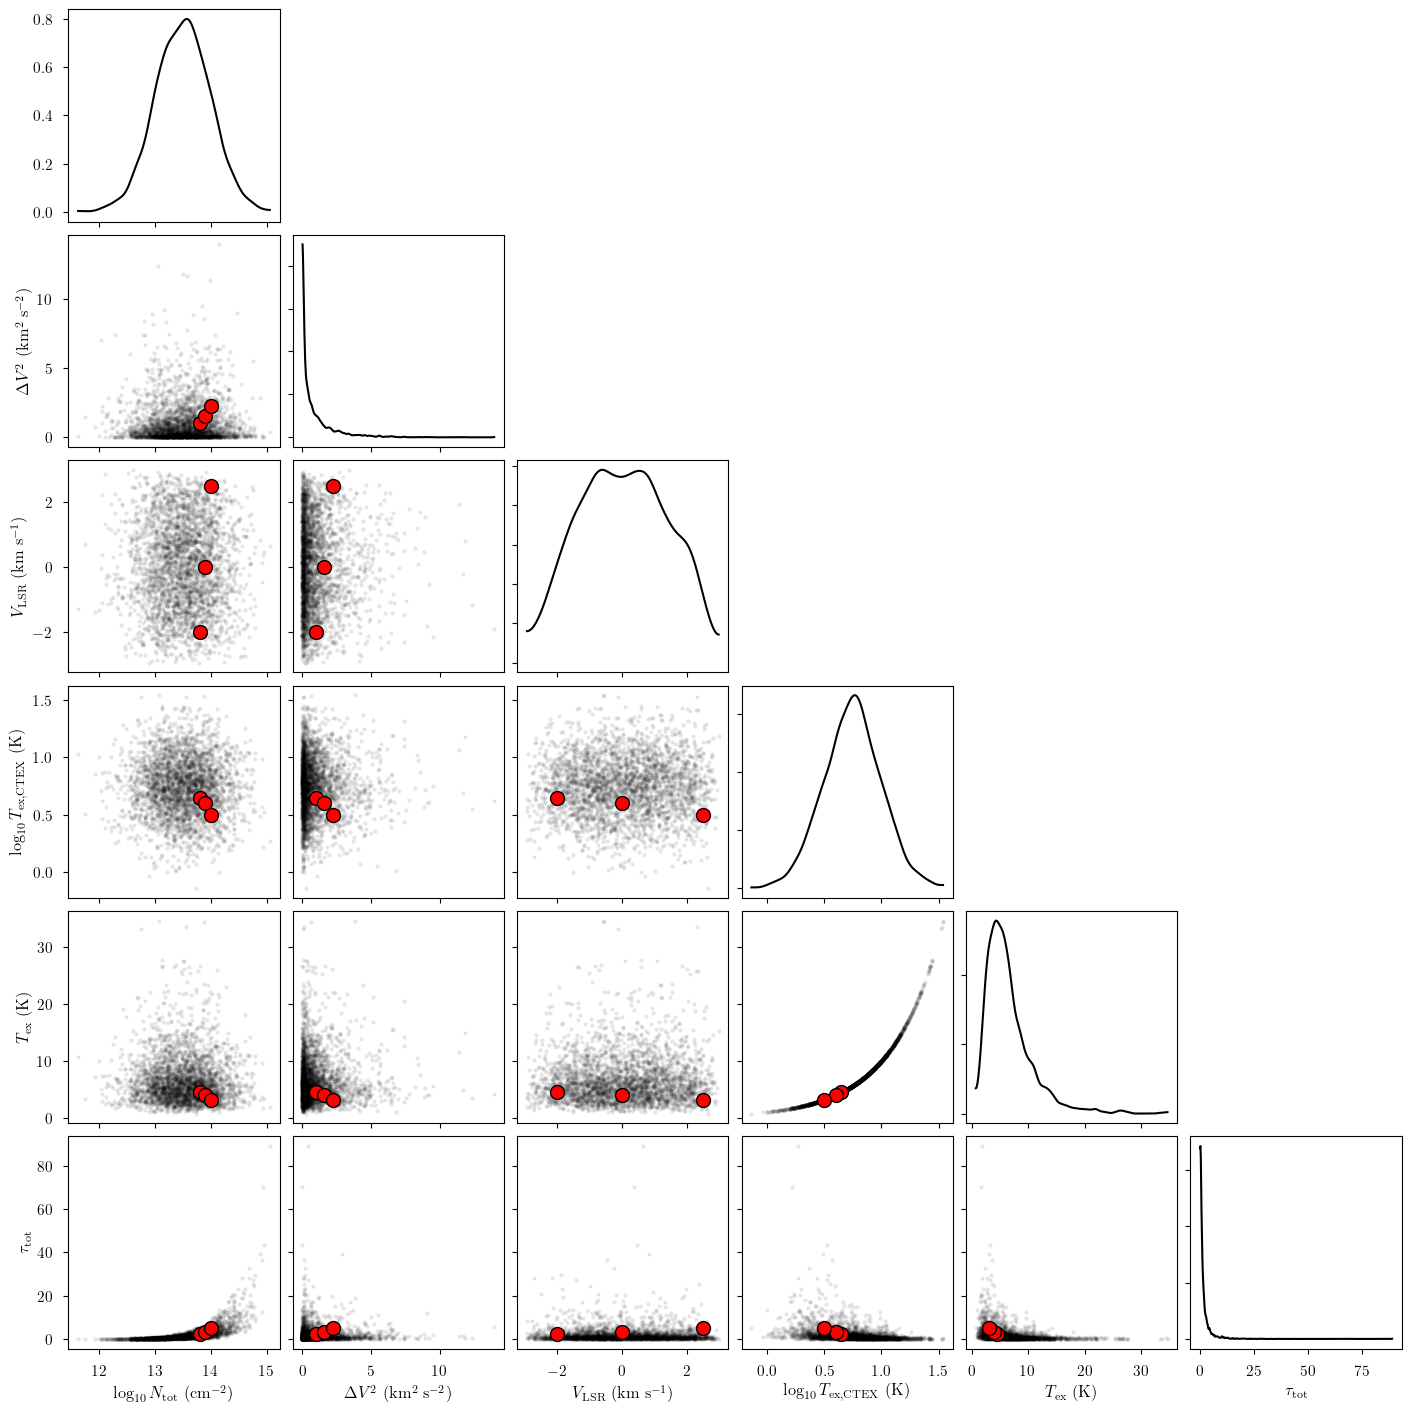

In [14]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [15]:
start = time.time()
model.fit(
    n = 1_000_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.005, # VI relative convergence threshold
    abs_tolerance = 0.005, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 26300
Interrupted at 26,299 [2%]: Average Loss = -762.32


Adding log-likelihood to trace


Output()

Runtime: 3.99 minutes


In [16]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1_norm[0]          0.048  0.044  -0.028    0.130      0.001   
baseline_12CN-2_norm[0]          0.069  0.058  -0.040    0.176      0.002   
log10_Ntot_norm[0]               0.677  0.016   0.649    0.706      0.000   
log10_Ntot_norm[1]               0.749  0.018   0.716    0.783      0.001   
log10_Ntot_norm[2]               0.947  0.042   0.866    1.024      0.001   
log10_Tex_CTEX_norm[0]          -0.467  0.009  -0.482   -0.449      0.000   
log10_Tex_CTEX_norm[1]          -0.579  0.009  -0.596   -0.562      0.000   
log10_Tex_CTEX_norm[2]          -0.993  0.009  -1.010   -0.978      0.000   
fwhm2_norm[0]                    0.986  0.043   0.904    1.061      0.001   
fwhm2_norm[1]                    1.673  0.079   1.529    1.819      0.003   
fwhm2_norm[2]                    2.255  0.226   1.869    2.714      0.007   
velocity_norm[0]                 0.165  0.002   0.163    0.168      0.000   
velocity_norm[1]                 0.499  0.002   0.495    0.504      0.000   
velocity_norm[2]                 0.918  0.006   0.908    0.928      0.000   
log10_Ntot[0]                   13.839  0.008  13.824   13.853      0.000   
log10_Ntot[1]                   13.875  0.009  13.858   13.891      0.000   
log10_Ntot[2]                   13.974  0.021  13.933   14.012      0.001   
fwhm2[0]                         0.986  0.043   0.904    1.061      0.001   
fwhm2[1]                         1.673  0.079   1.529    1.819      0.003   
fwhm2[2]                         2.255  0.226   1.869    2.714      0.007   
velocity[0]                     -2.008  0.009  -2.025   -1.991      0.000   
velocity[1]                     -0.004  0.014  -0.028    0.022      0.000   
velocity[2]                      2.505  0.033   2.448    2.569      0.001   
log10_Tex_CTEX[0]                0.633  0.002   0.629    0.638      0.000   
log10_Tex_CTEX[1]                0.605  0.002   0.601    0.610      0.000   
log10_Tex_CTEX[2]                0.502  0.002   0.497    0.506      0.000   
CTEX_weights[0, 0 0 1 1 -- --]   2.000  0.000   2.000    2.000      0.000   
CTEX_weights[0, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[0, 1 0 1 1 -- --]   0.566  0.004   0.559    0.572      0.000   
CTEX_weights[0, 1 0 1 2 -- --]   1.131  0.007   1.117    1.144      0.000   
CTEX_weights[0, 1 0 2 1 -- --]   0.563  0.004   0.556    0.570      0.000   
CTEX_weights[0, 1 0 2 2 -- --]   1.127  0.007   1.113    1.140      0.000   
CTEX_weights[0, 1 0 2 3 -- --]   1.690  0.011   1.669    1.710      0.000   
CTEX_weights[1, 0 0 1 1 -- --]   2.000  0.000   1.999    2.000      0.000   
CTEX_weights[1, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[1, 1 0 1 1 -- --]   0.520  0.004   0.513    0.527      0.000   
CTEX_weights[1, 1 0 1 2 -- --]   1.039  0.007   1.025    1.053      0.000   
CTEX_weights[1, 1 0 2 1 -- --]   0.517  0.004   0.511    0.524      0.000   
CTEX_weights[1, 1 0 2 2 -- --]   1.035  0.007   1.021    1.049      0.000   
CTEX_weights[1, 1 0 2 3 -- --]   1.553  0.011   1.532    1.574      0.000   
CTEX_weights[2, 0 0 1 1 -- --]   1.999  0.000   1.999    1.999      0.000   
CTEX_weights[2, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[2, 1 0 1 1 -- --]   0.362  0.003   0.356    0.367      0.000   
CTEX_weights[2, 1 0 1 2 -- --]   0.723  0.006   0.711    0.734      0.000   
CTEX_weights[2, 1 0 2 1 -- --]   0.360  0.003   0.354    0.365      0.000   
CTEX_weights[2, 1 0 2 2 -- --]   0.719  0.006   0.707    0.730      0.000   
CTEX_weights[2, 1 0 2 3 -- --]   1.079  0.009   1.061    1.095      0.000   
Tex[0]                           4.299  0.023   4.257    4.340      0.001   
Tex[1]                           4.029  0.021   3.990    4.070      0.001   
Tex[2]                           3.175  0.016   3.144    3.203      0.001   
tau[113123.3701, 0]              0.031  0.001   0.030    0.032      0.000   
tau[113123.3701, 1]           

Sampling: [12CN-1, 12CN-2]


Output()

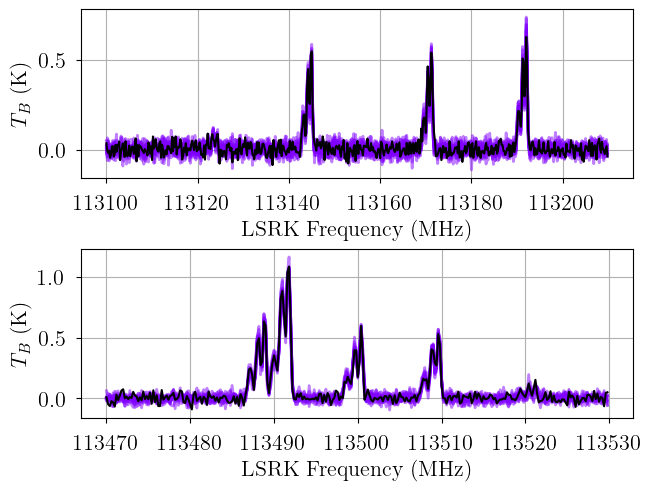

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [18]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.005,
        "abs_tolerance": 0.005,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 26300
Interrupted at 26,299 [2%]: Average Loss = -762.32
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, log10_Ntot_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Adding log-likelihood to trace


Output()

Runtime: 5.53 minutes


In [19]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [20]:
print("solutions:", model.solutions)
az.summary(model.trace.solution_0)
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeW

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1_norm[0]          0.046  0.043  -0.031    0.130      0.000   
baseline_12CN-2_norm[0]          0.069  0.062  -0.050    0.180      0.001   
log10_Ntot_norm[0]               0.675  0.044   0.589    0.752      0.001   
log10_Ntot_norm[1]               0.743  0.055   0.640    0.849      0.001   
log10_Ntot_norm[2]               0.942  0.128   0.701    1.183      0.002   
log10_Tex_CTEX_norm[0]          -0.463  0.027  -0.512   -0.415      0.000   
log10_Tex_CTEX_norm[1]          -0.577  0.030  -0.635   -0.522      0.000   
log10_Tex_CTEX_norm[2]          -0.989  0.026  -1.035   -0.940      0.000   
fwhm2_norm[0]                    0.988  0.051   0.894    1.085      0.001   
fwhm2_norm[1]                    1.666  0.112   1.464    1.881      0.001   
fwhm2_norm[2]                    2.285  0.273   1.781    2.799      0.003   
velocity_norm[0]                 0.165  0.002   0.162    0.168      0.000   
velocity_norm[1]                 0.500  0.003   0.494    0.504      0.000   
velocity_norm[2]                 0.918  0.007   0.905    0.930      0.000   
log10_Ntot[0]                   13.837  0.022  13.794   13.876      0.000   
log10_Ntot[1]                   13.872  0.028  13.820   13.925      0.000   
log10_Ntot[2]                   13.971  0.064  13.851   14.091      0.001   
fwhm2[0]                         0.988  0.051   0.894    1.085      0.001   
fwhm2[1]                         1.666  0.112   1.464    1.881      0.001   
fwhm2[2]                         2.285  0.273   1.781    2.799      0.003   
velocity[0]                     -2.010  0.011  -2.029   -1.990      0.000   
velocity[1]                     -0.003  0.016  -0.033    0.025      0.000   
velocity[2]                      2.506  0.039   2.432    2.578      0.000   
log10_Tex_CTEX[0]                0.634  0.007   0.622    0.646      0.000   
log10_Tex_CTEX[1]                0.606  0.007   0.591    0.619      0.000   
log10_Tex_CTEX[2]                0.503  0.006   0.491    0.515      0.000   
CTEX_weights[0, 0 0 1 1 -- --]   2.000  0.000   2.000    2.000      0.000   
CTEX_weights[0, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[0, 1 0 1 1 -- --]   0.567  0.011   0.547    0.587      0.000   
CTEX_weights[0, 1 0 1 2 -- --]   1.133  0.022   1.093    1.173      0.000   
CTEX_weights[0, 1 0 2 1 -- --]   0.565  0.011   0.544    0.585      0.000   
CTEX_weights[0, 1 0 2 2 -- --]   1.129  0.022   1.089    1.169      0.000   
CTEX_weights[0, 1 0 2 3 -- --]   1.694  0.033   1.634    1.754      0.000   
CTEX_weights[1, 0 0 1 1 -- --]   2.000  0.000   1.999    2.000      0.000   
CTEX_weights[1, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[1, 1 0 1 1 -- --]   0.521  0.012   0.497    0.543      0.000   
CTEX_weights[1, 1 0 1 2 -- --]   1.041  0.024   0.994    1.085      0.000   
CTEX_weights[1, 1 0 2 1 -- --]   0.518  0.012   0.495    0.540      0.000   
CTEX_weights[1, 1 0 2 2 -- --]   1.037  0.024   0.990    1.081      0.000   
CTEX_weights[1, 1 0 2 3 -- --]   1.555  0.036   1.486    1.622      0.000   
CTEX_weights[2, 0 0 1 1 -- --]   1.999  0.000   1.999    1.999      0.000   
CTEX_weights[2, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000      0.000   
CTEX_weights[2, 1 0 1 1 -- --]   0.363  0.009   0.346    0.380      0.000   
CTEX_weights[2, 1 0 1 2 -- --]   0.725  0.018   0.692    0.760      0.000   
CTEX_weights[2, 1 0 2 1 -- --]   0.361  0.009   0.344    0.378      0.000   
CTEX_weights[2, 1 0 2 2 -- --]   0.722  0.018   0.688    0.756      0.000   
CTEX_weights[2, 1 0 2 3 -- --]   1.083  0.028   1.033    1.135      0.000   
Tex[0]                           4.307  0.066   4.187    4.430      0.001   
Tex[1]                           4.035  0.069   3.902    4.163      0.001   
Tex[2]                           3.182  0.047   3.095    3.271      0.001   
tau[113123.3701, 0]              0.031  0.002   0.027    0.035      0.000   
tau[113123.3701, 1]           

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

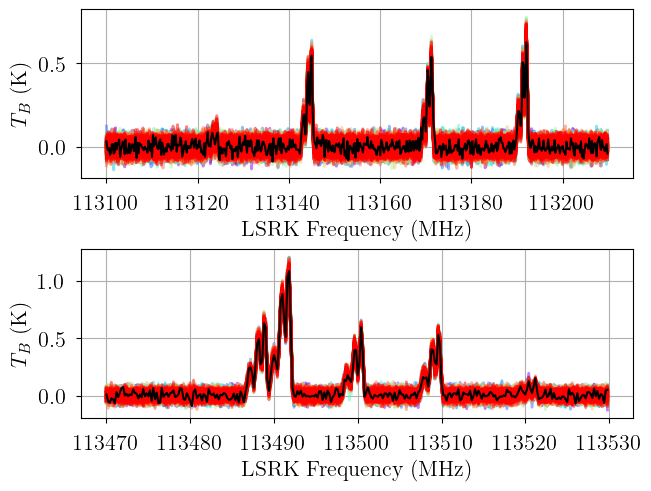

In [21]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

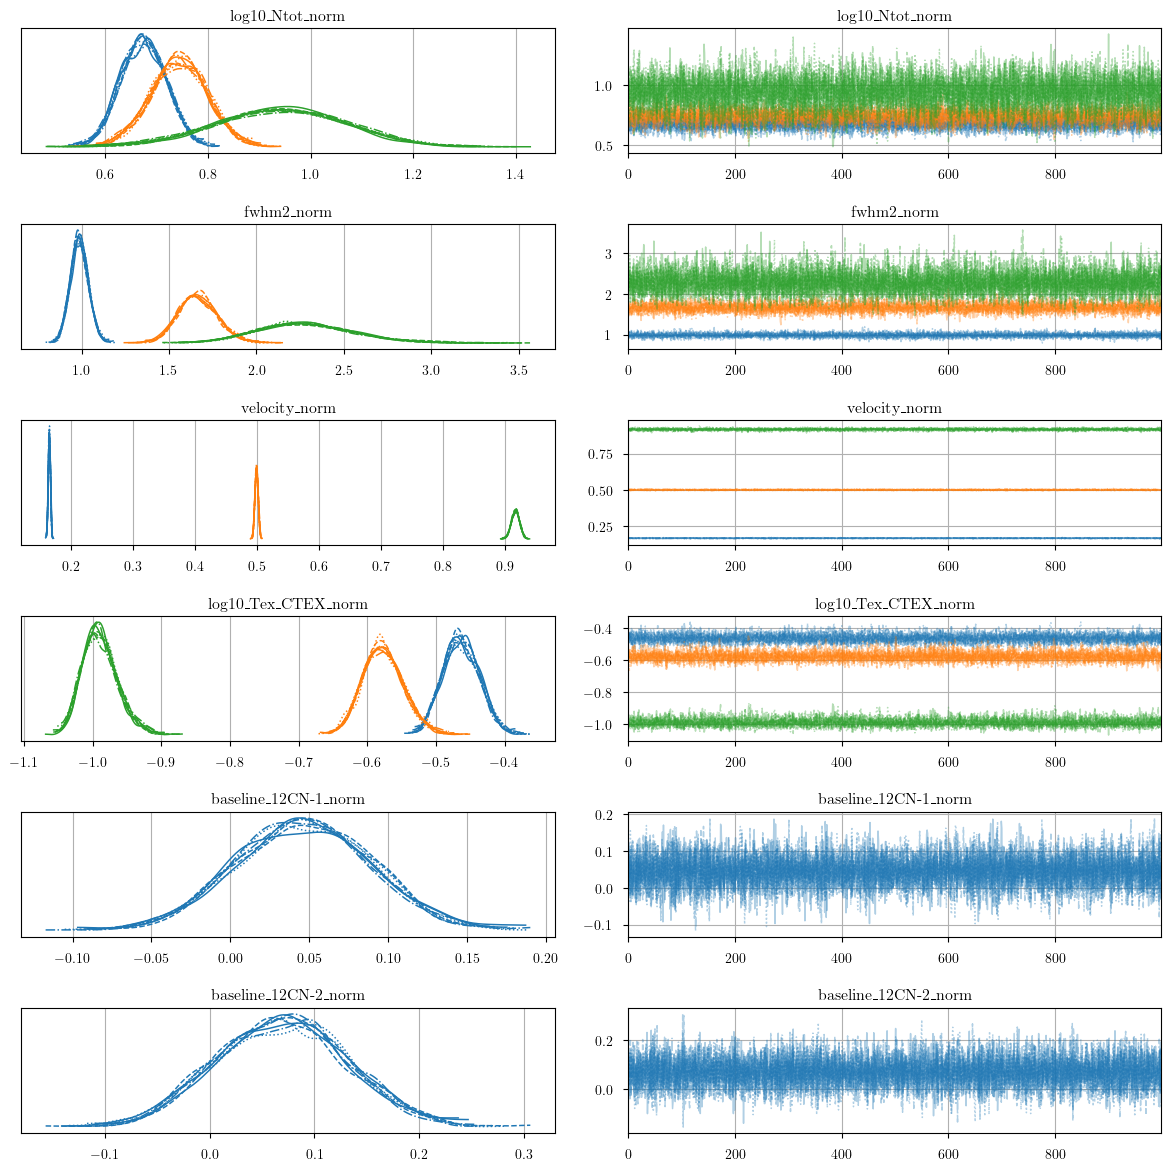

In [22]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. First, the free parameters for all clouds. Keep an eye out for any strong degeneracies or non-linear correlations. If present, then these features can cause the posterior sampling to be inefficient. It may be worth re-parameterizing your model to remove these effects. Alternatively, increasing `tune` and `target_accept` can help.

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm']


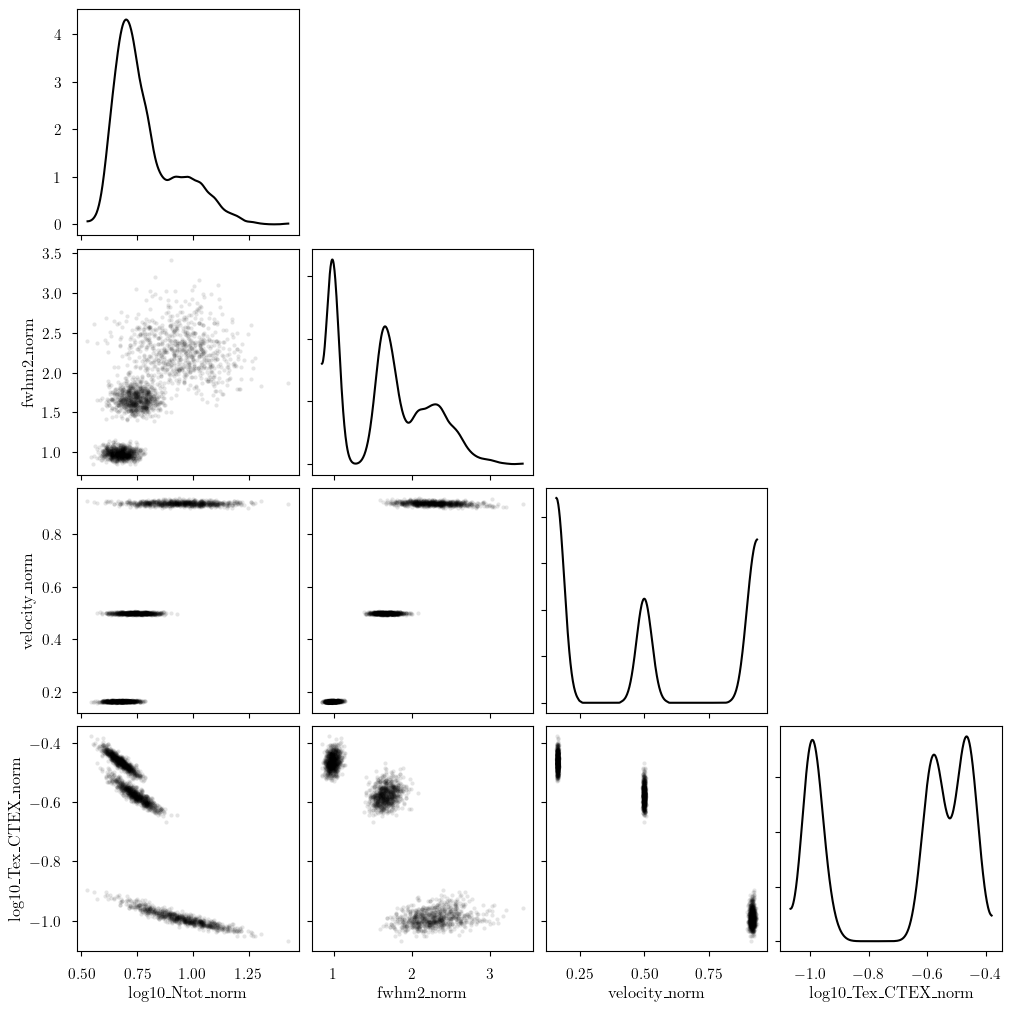

In [23]:
var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

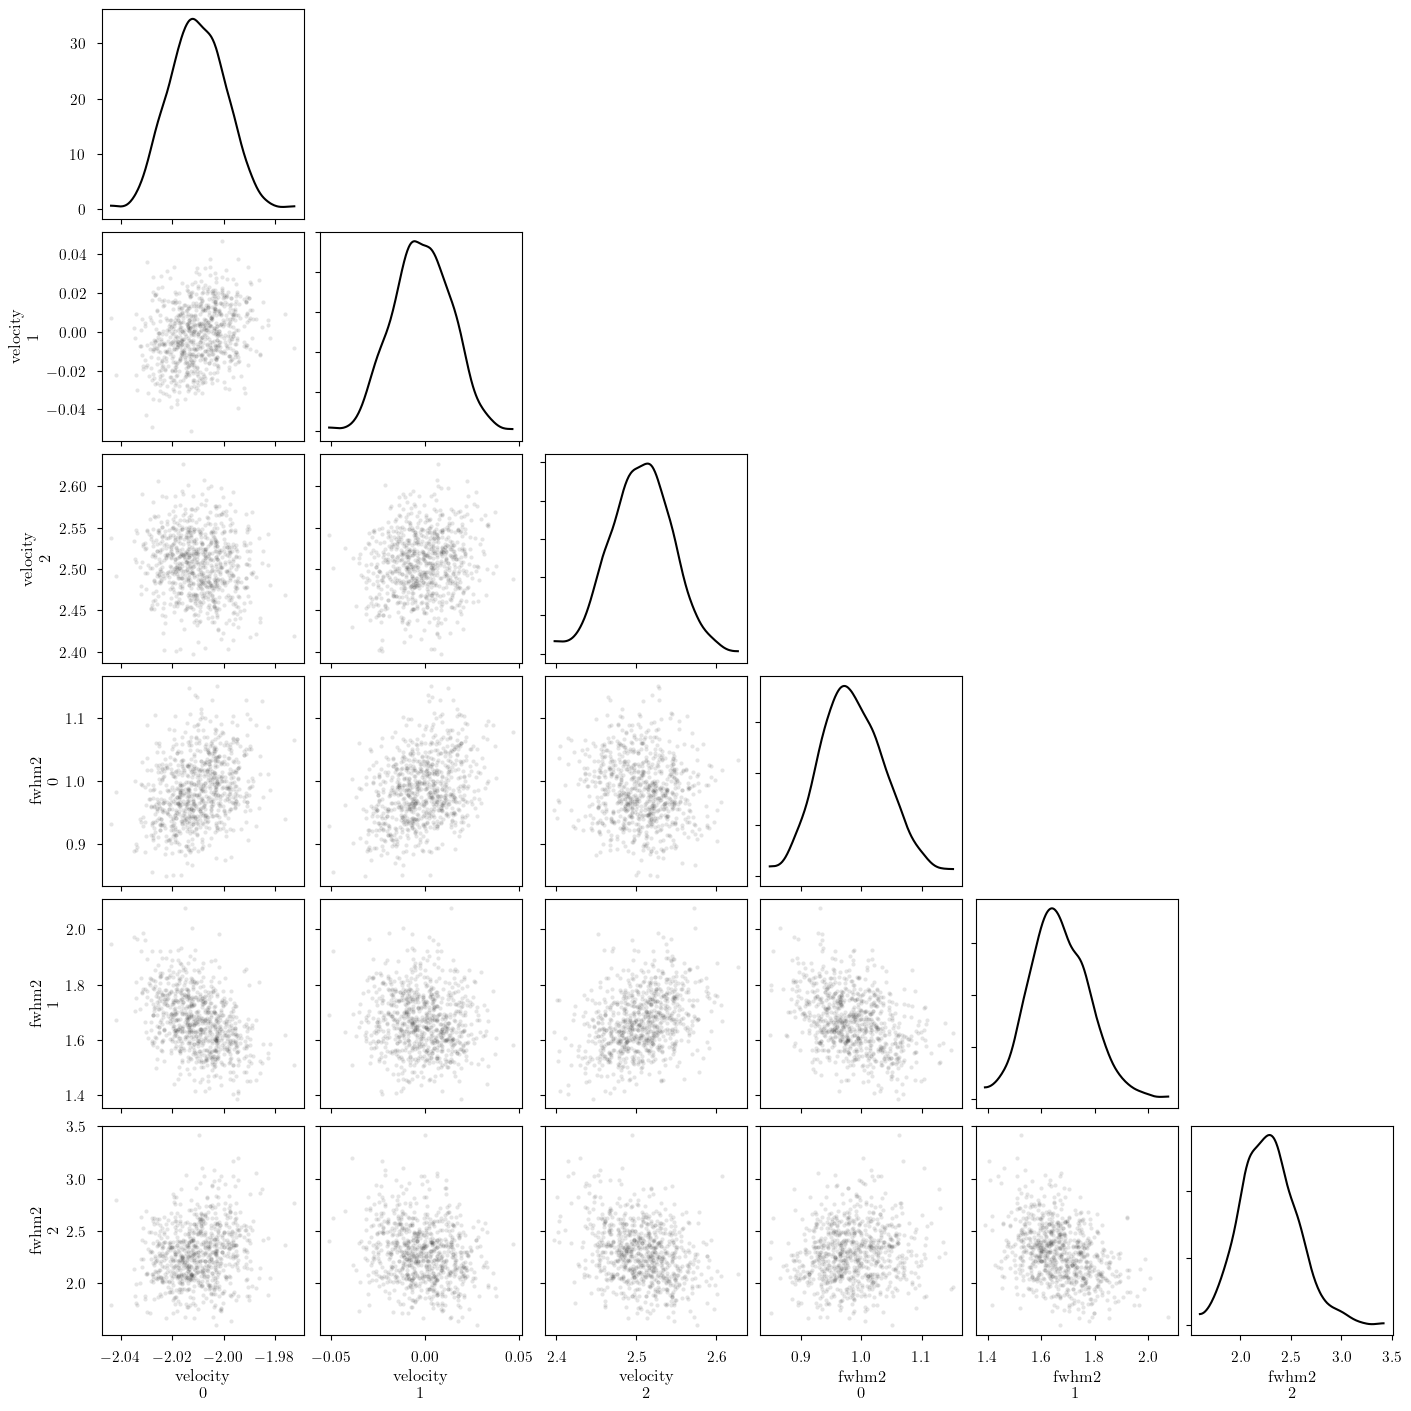

In [24]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    ["velocity", "fwhm2"], # var_names to plot
    combine_dims=None, # do not concatenate clouds
    kind="scatter", # plot type
)

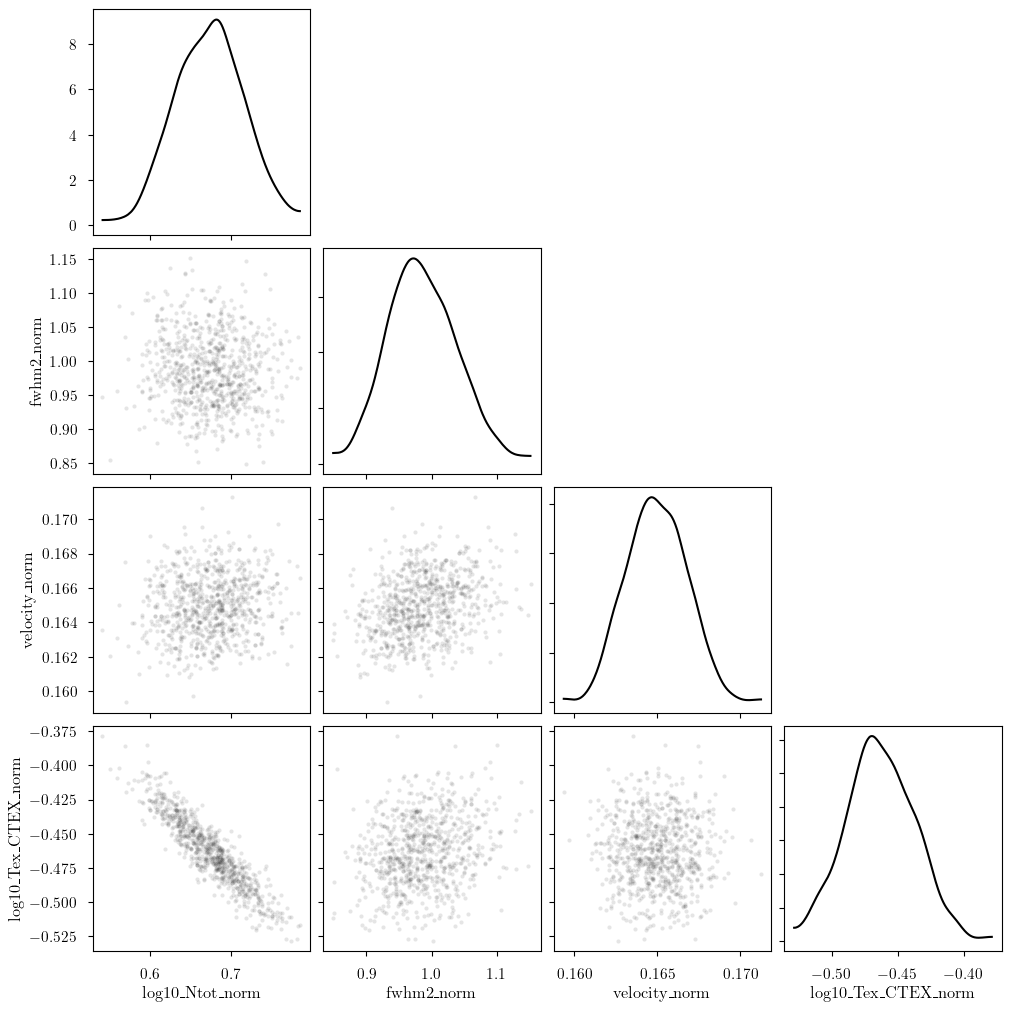

In [25]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

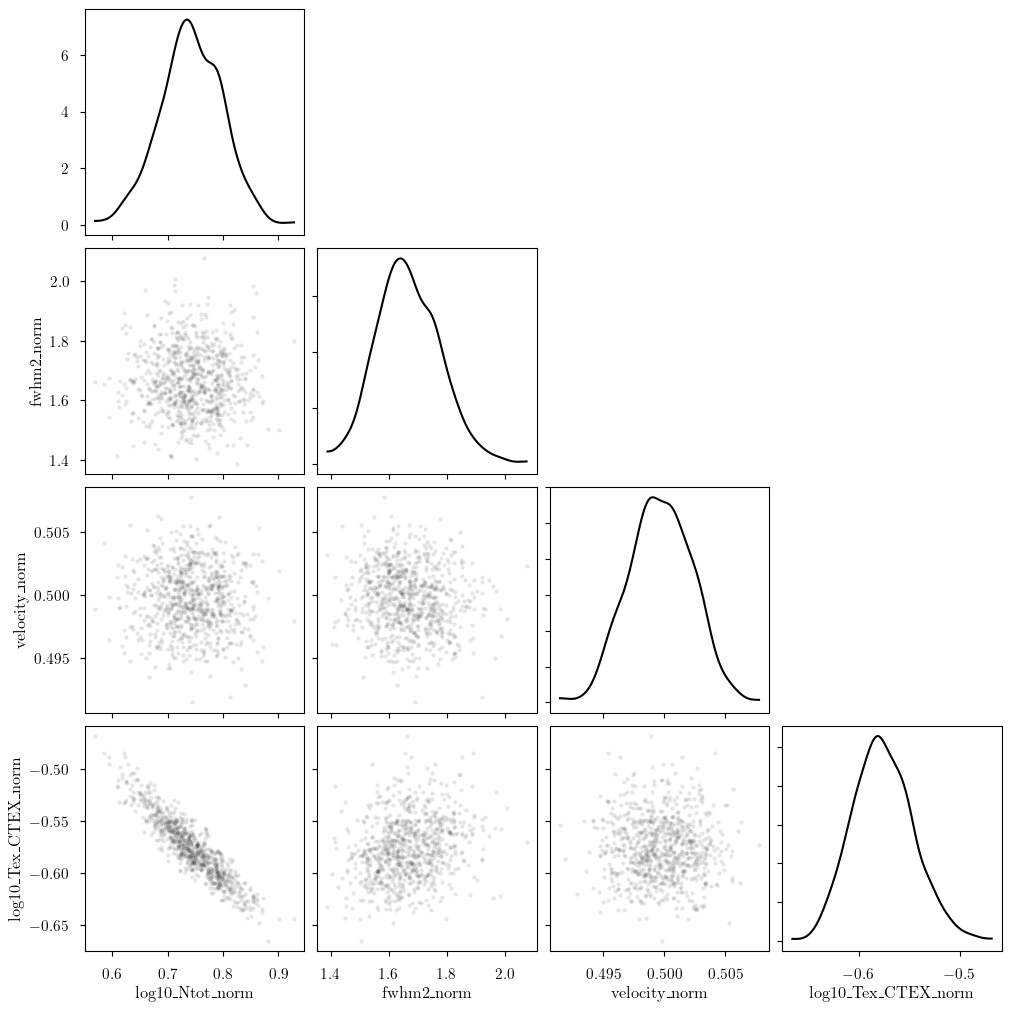

In [26]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

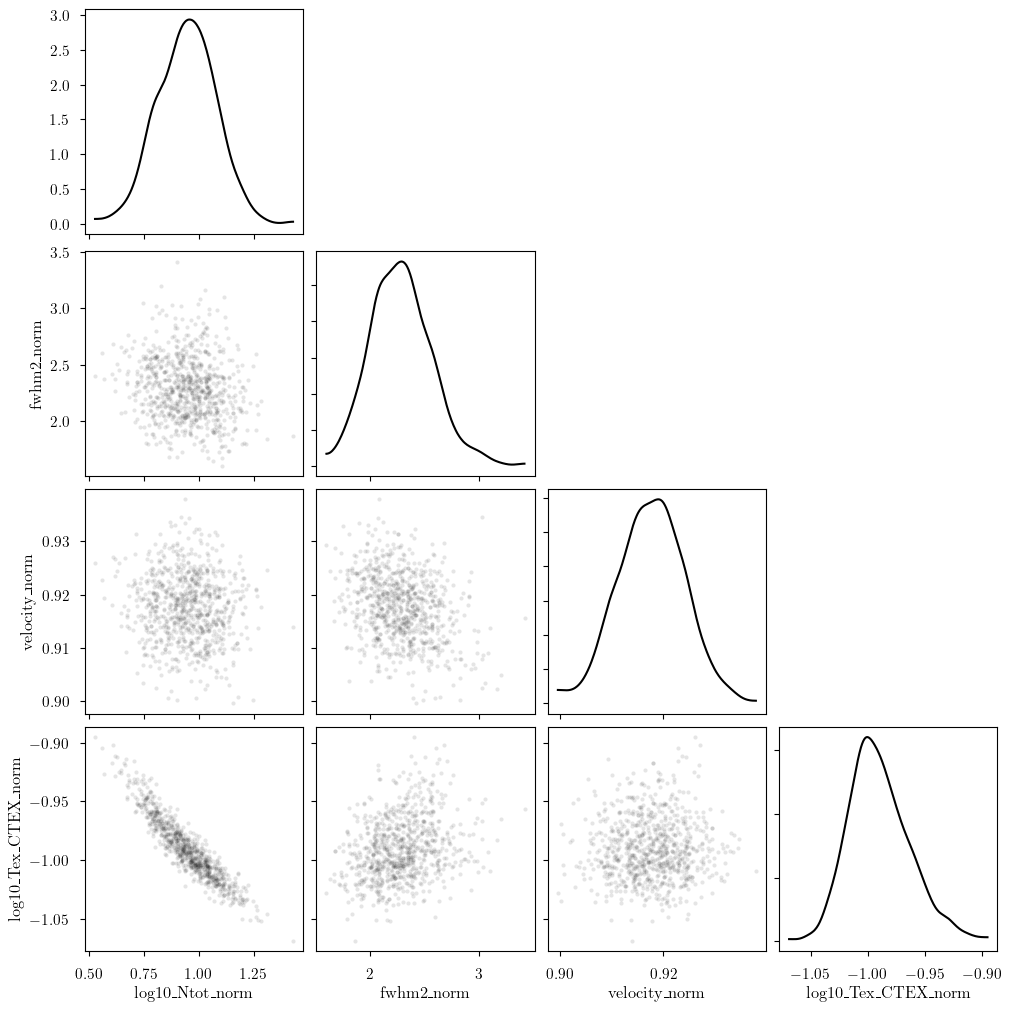

In [27]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

The red points represent the simulation parameters for the deterministic quantities.

['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'Tex', 'tau_total']


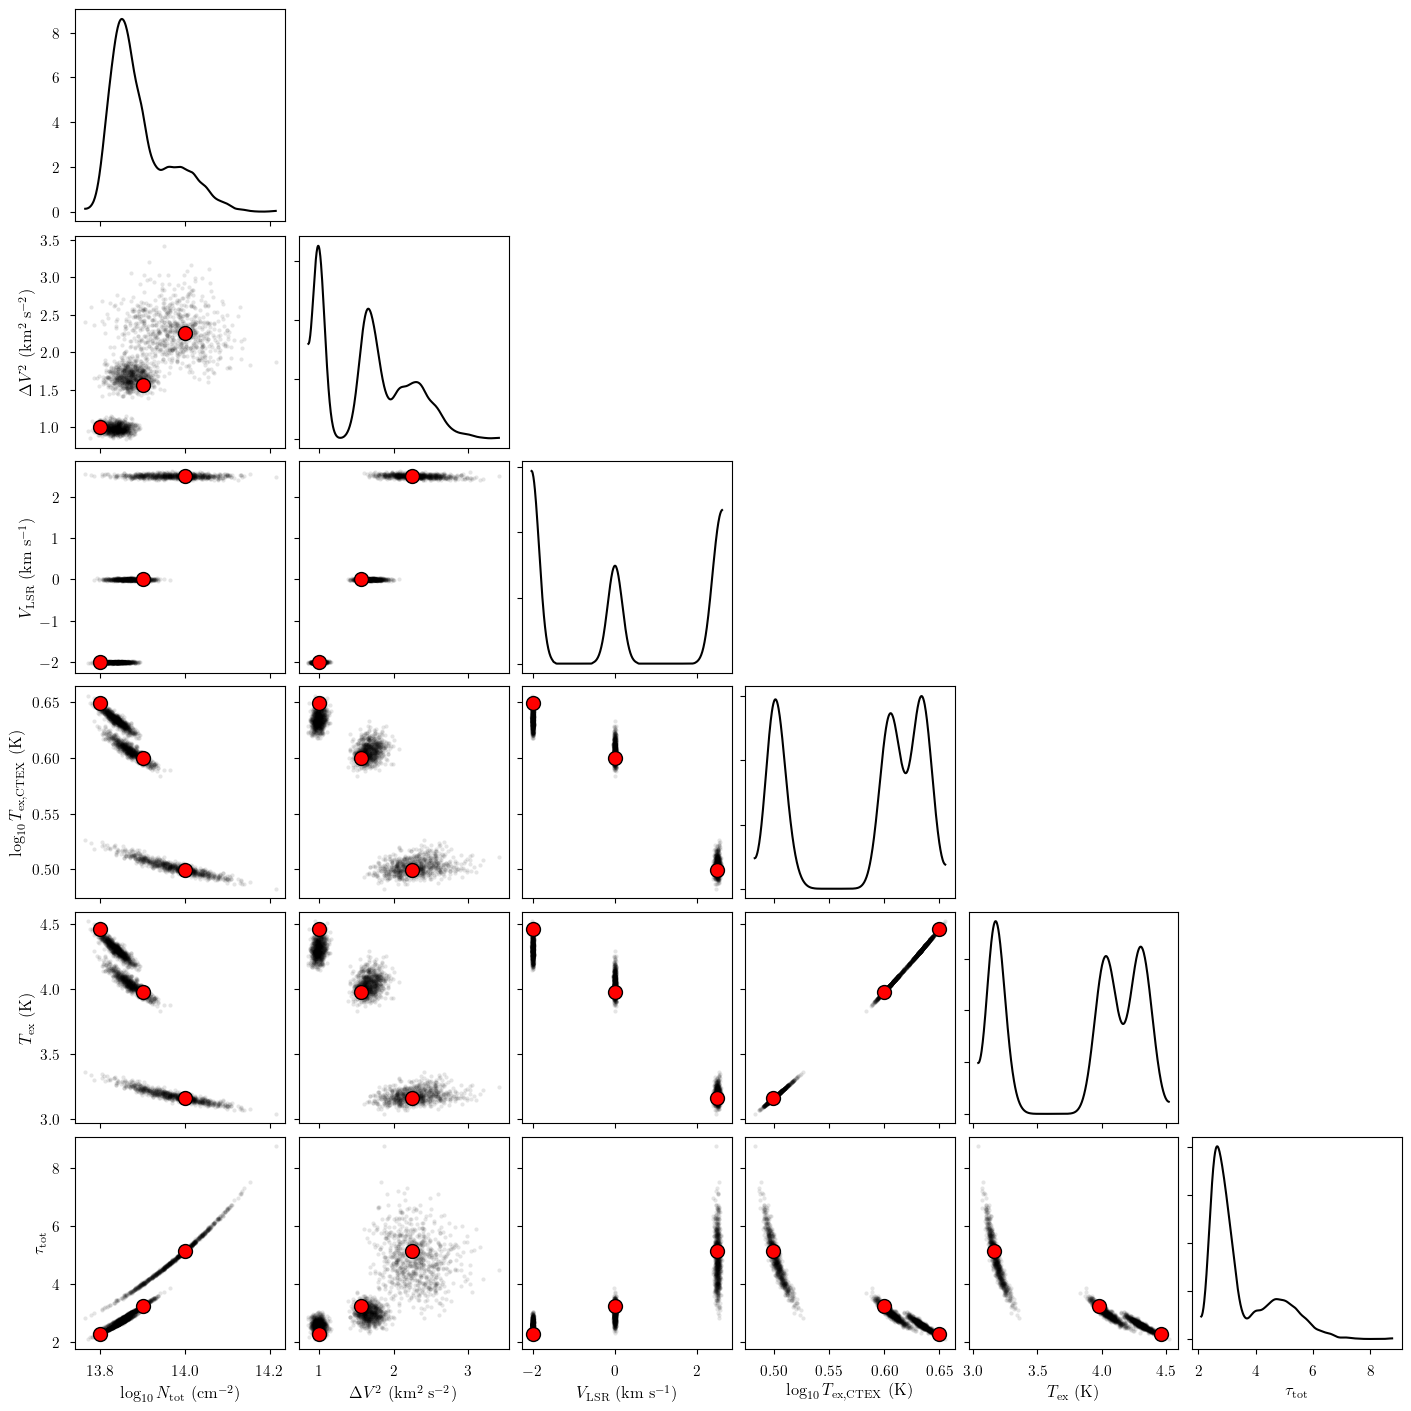

In [28]:
var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)

_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [29]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

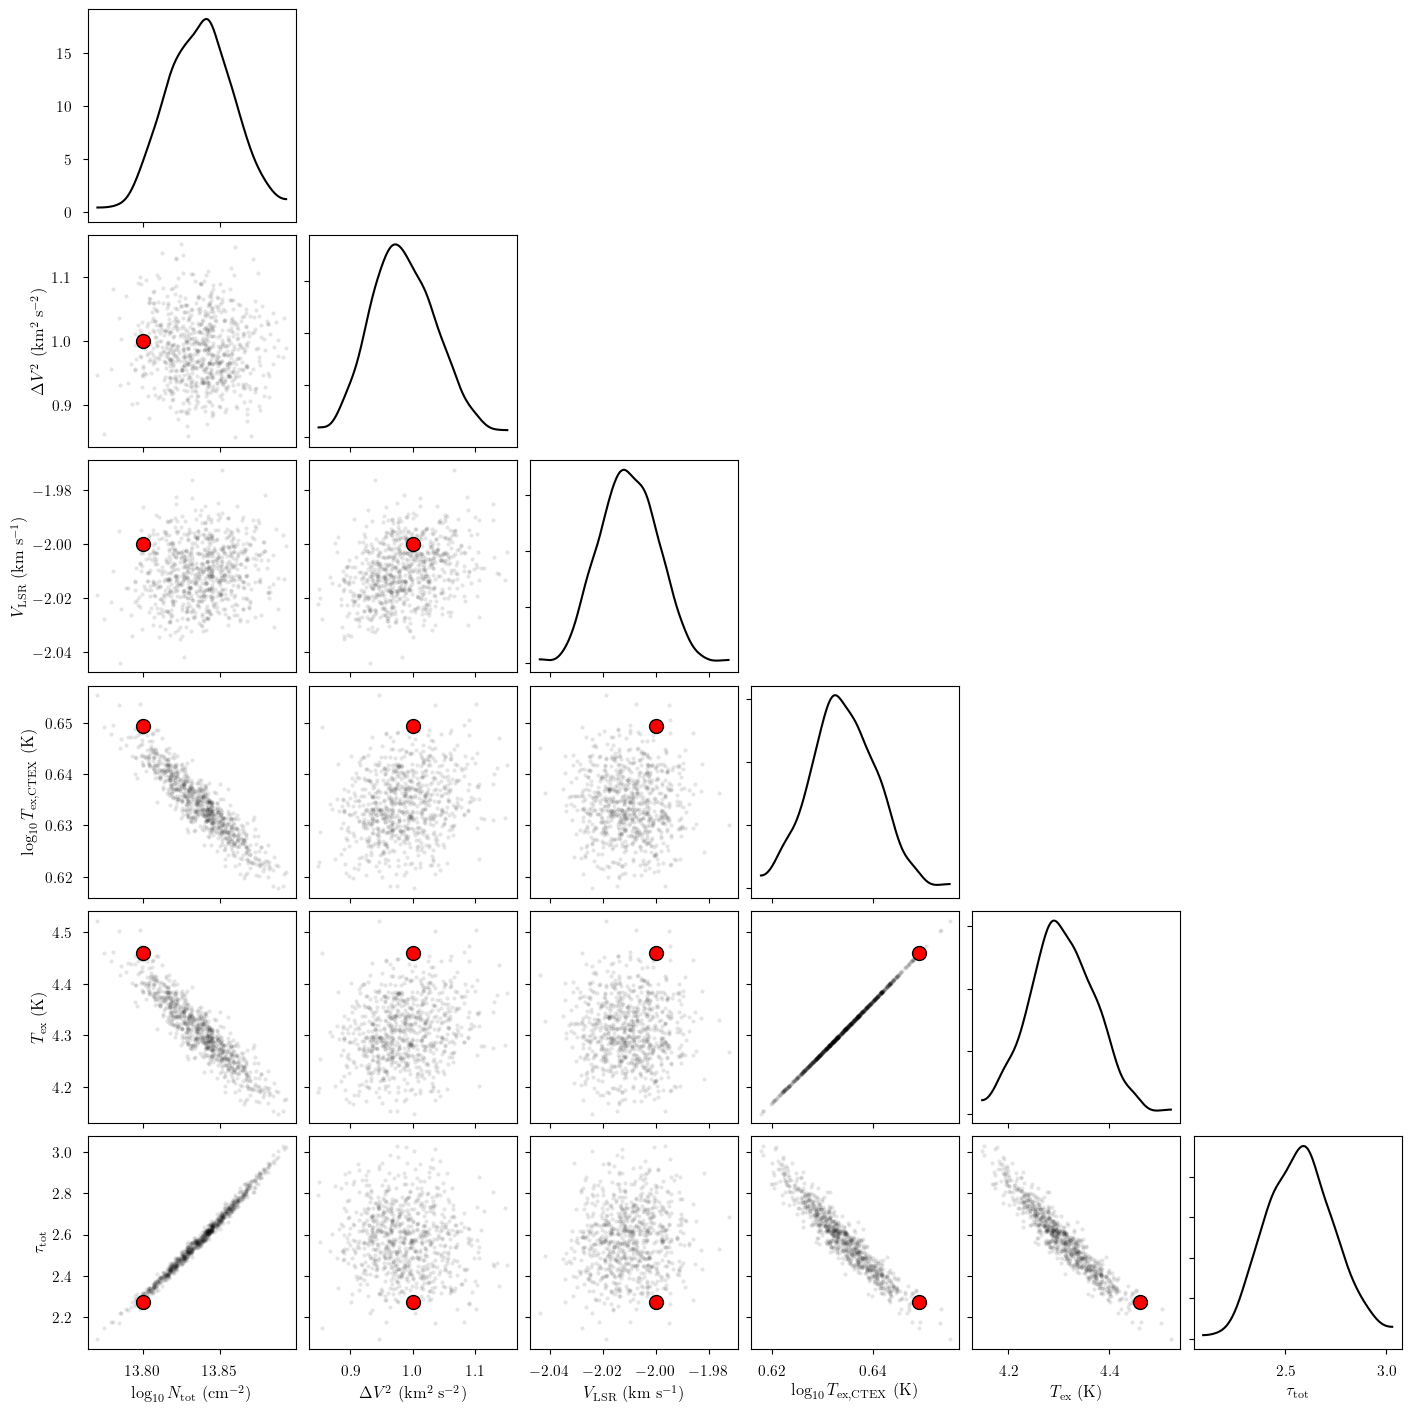

In [30]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

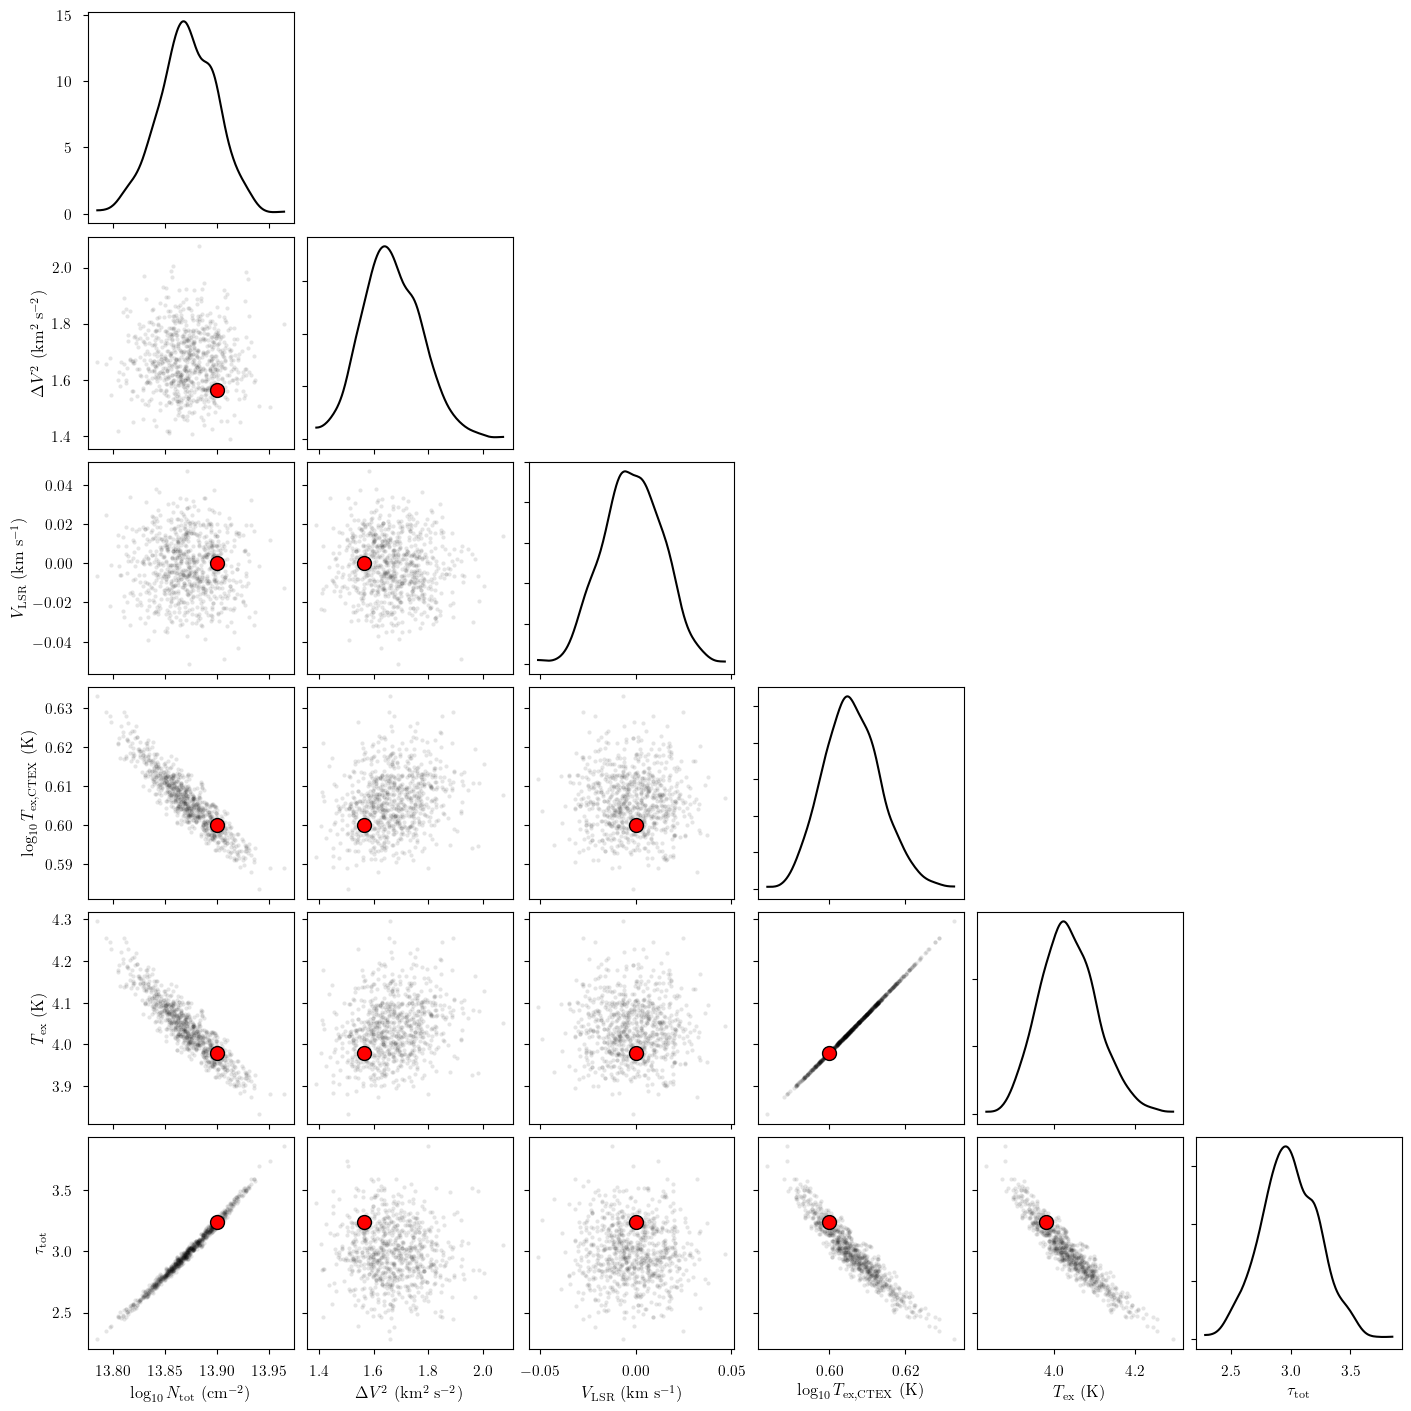

In [31]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

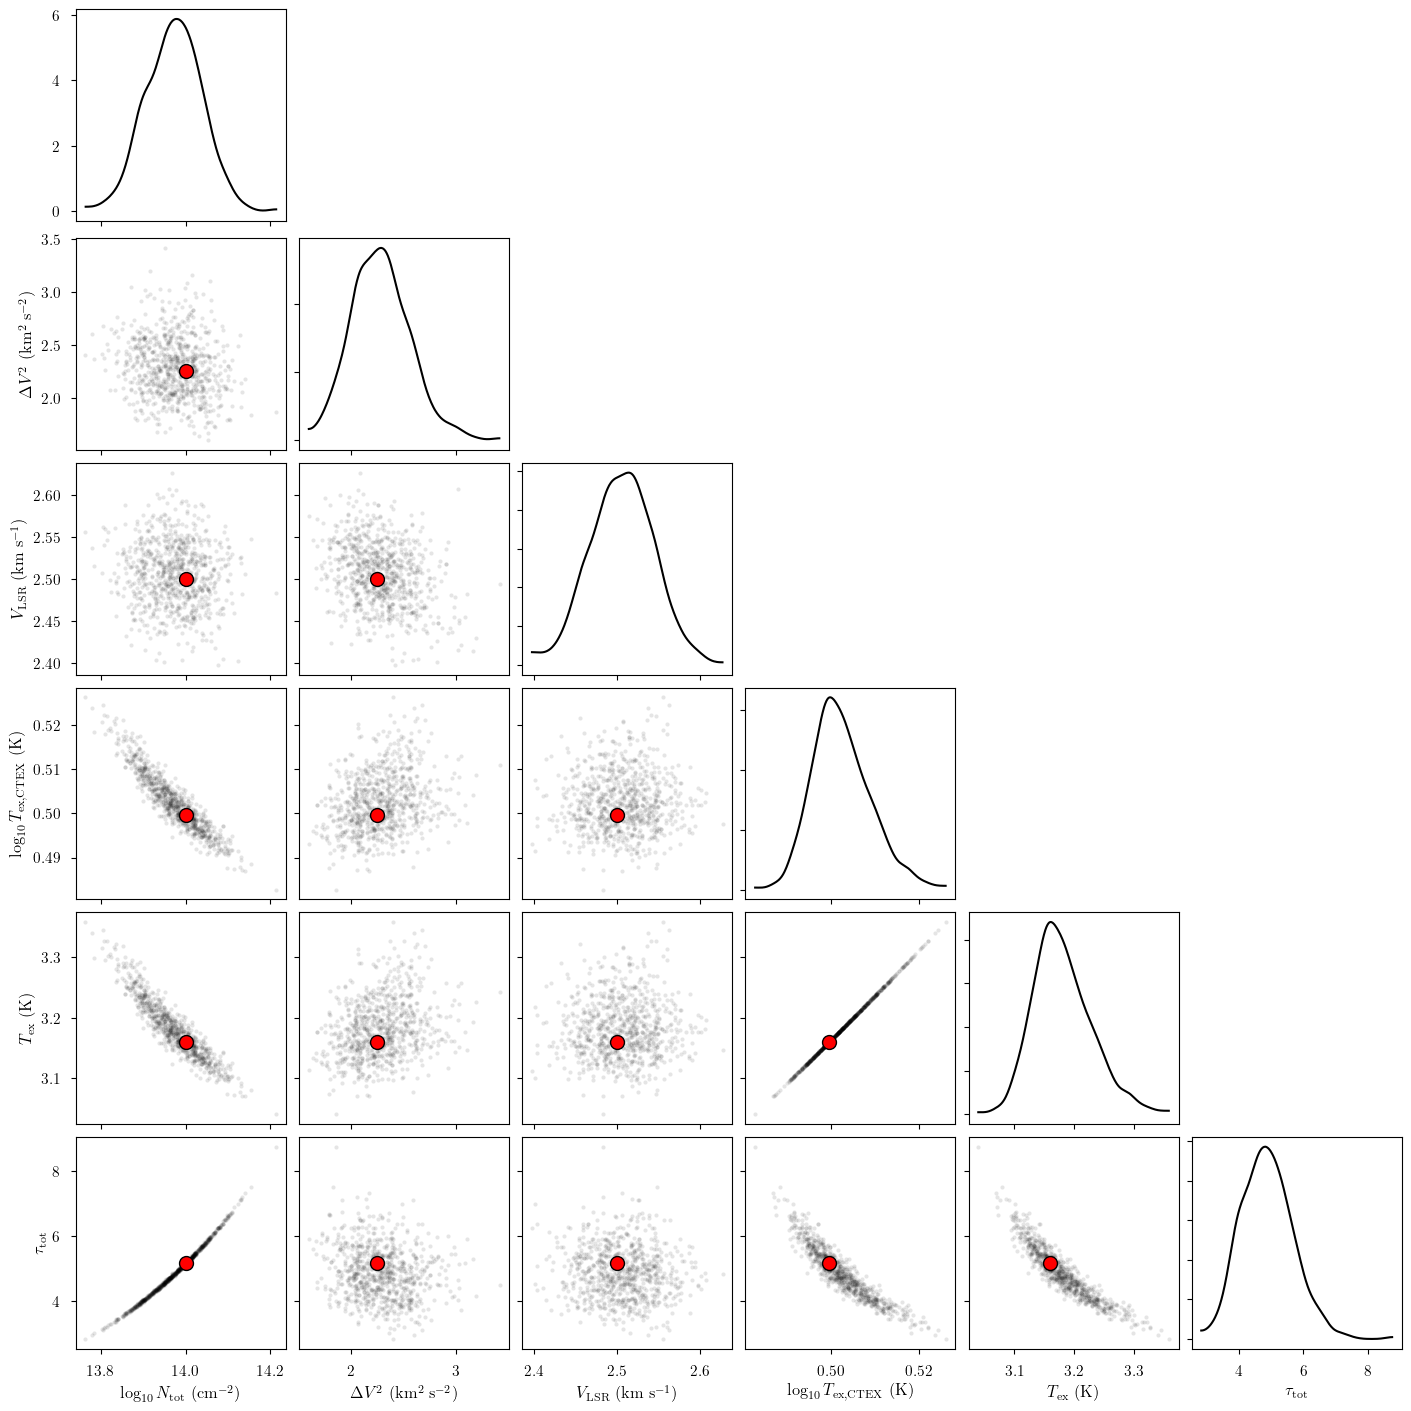

In [32]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [33]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -3413.0028007805786


mean     sd  hdi_3%  hdi_97%
baseline_12CN-1_norm[0]          0.046  0.043  -0.031    0.130
baseline_12CN-2_norm[0]          0.069  0.062  -0.050    0.180
log10_Ntot_norm[0]               0.675  0.044   0.589    0.752
log10_Ntot_norm[1]               0.743  0.055   0.640    0.849
log10_Ntot_norm[2]               0.942  0.128   0.701    1.183
log10_Tex_CTEX_norm[0]          -0.463  0.027  -0.512   -0.415
log10_Tex_CTEX_norm[1]          -0.577  0.030  -0.635   -0.522
log10_Tex_CTEX_norm[2]          -0.989  0.026  -1.035   -0.940
fwhm2_norm[0]                    0.988  0.051   0.894    1.085
fwhm2_norm[1]                    1.666  0.112   1.464    1.881
fwhm2_norm[2]                    2.285  0.273   1.781    2.799
velocity_norm[0]                 0.165  0.002   0.162    0.168
velocity_norm[1]                 0.500  0.003   0.494    0.504
velocity_norm[2]                 0.918  0.007   0.905    0.930
log10_Ntot[0]                   13.837  0.022  13.794   13.876
log10_Ntot[1]                   13.872  0.028  13.820   13.925
log10_Ntot[2]                   13.971  0.064  13.851   14.091
fwhm2[0]                         0.988  0.051   0.894    1.085
fwhm2[1]                         1.666  0.112   1.464    1.881
fwhm2[2]                         2.285  0.273   1.781    2.799
velocity[0]                     -2.010  0.011  -2.029   -1.990
velocity[1]                     -0.003  0.016  -0.033    0.025
velocity[2]                      2.506  0.039   2.432    2.578
log10_Tex_CTEX[0]                0.634  0.007   0.622    0.646
log10_Tex_CTEX[1]                0.606  0.007   0.591    0.619
log10_Tex_CTEX[2]                0.503  0.006   0.491    0.515
CTEX_weights[0, 0 0 1 1 -- --]   2.000  0.000   2.000    2.000
CTEX_weights[0, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000
CTEX_weights[0, 1 0 1 1 -- --]   0.567  0.011   0.547    0.587
CTEX_weights[0, 1 0 1 2 -- --]   1.133  0.022   1.093    1.173
CTEX_weights[0, 1 0 2 1 -- --]   0.565  0.011   0.544    0.585
CTEX_weights[0, 1 0 2 2 -- --]   1.129  0.022   1.089    1.169
CTEX_weights[0, 1 0 2 3 -- --]   1.694  0.033   1.634    1.754
CTEX_weights[1, 0 0 1 1 -- --]   2.000  0.000   1.999    2.000
CTEX_weights[1, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000
CTEX_weights[1, 1 0 1 1 -- --]   0.521  0.012   0.497    0.543
CTEX_weights[1, 1 0 1 2 -- --]   1.041  0.024   0.994    1.085
CTEX_weights[1, 1 0 2 1 -- --]   0.518  0.012   0.495    0.540
CTEX_weights[1, 1 0 2 2 -- --]   1.037  0.024   0.990    1.081
CTEX_weights[1, 1 0 2 3 -- --]   1.555  0.036   1.486    1.622
CTEX_weights[2, 0 0 1 1 -- --]   1.999  0.000   1.999    1.999
CTEX_weights[2, 0 0 1 2 -- --]   4.000  0.000   4.000    4.000
CTEX_weights[2, 1 0 1 1 -- --]   0.363  0.009   0.346    0.380
CTEX_weights[2, 1 0 1 2 -- --]   0.725  0.018   0.692    0.760
CTEX_weights[2, 1 0 2 1 -- --]   0.361  0.009   0.344    0.378
CTEX_weights[2, 1 0 2 2 -- --]   0.722  0.018   0.688    0.756
CTEX_weights[2, 1 0 2 3 -- --]   1.083  0.028   1.033    1.135
Tex[0]                           4.307  0.066   4.187    4.430
Tex[1]                           4.035  0.069   3.902    4.163
Tex[2]                           3.182  0.047   3.095    3.271
tau[113123.3701, 0]              0.031  0.002   0.027    0.035
tau[113123.3701, 1]              0.036  0.003   0.031    0.042
tau[113123.3701, 2]              0.059  0.009   0.041    0.076
tau[113144.1573, 0]              0.255  0.017   0.224    0.286
tau[113144.1573, 1]              0.296  0.024   0.250    0.340
tau[113144.1573, 2]              0.479  0.077   0.338    0.623
tau[113170.4915, 0]              0.249  0.016   0.218    0.279
tau[113170.4915, 1]              0.289  0.023   0.244    0.332
tau[113170.4915, 2]              0.468  0.075   0.330    0.609
tau[113191.2787, 0]              0.323  0.021   0.284    0.362
tau[113191.2787, 1]              0.375  0.030   0.317    0.432
tau[113191.2787, 2]              0.608  0.098   0.429    0.791
tau[113488.1202, 0]              0.324  0.021   0.285    0.364
ta